In [1]:
import os
print(os.getcwd())


c:\Users\chira\OneDrive\Desktop\smartviz_chatbot_project\notebooks


In [2]:
os.chdir('C:/Users/chira/Downloads/athira-downloads/smartviz_chatbot_project')


In [3]:
!pip install seaborn 
!pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: C:\Users\chira\Downloads\athira-downloads\smartviz_chatbot_project\venv\Scripts\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: C:\Users\chira\Downloads\athira-downloads\smartviz_chatbot_project\venv\Scripts\python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine


# Load from local CSVs (placed in the 'data/' folder)
hierarchy_df = pd.read_csv('data/metrics_app_hierarchy_202506111454_backup.csv')
timeagg_df = pd.read_csv('data/metrics_app_timeaggregated_202507091430_backup-1752067848951_cleaned.csv')




In [5]:
hierarchy_df.shape

(32, 11)

In [6]:
timeagg_df.shape

(2411456, 14)

In [7]:
# Display basic info and first few rows
print("\n Hierarchy Dataset:")
print(hierarchy_df.info())
print(hierarchy_df.head())


 Hierarchy Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            32 non-null     object 
 1   display_name    32 non-null     object 
 2   hierarchy_type  32 non-null     object 
 3   parent          32 non-null     object 
 4   geometry_id     32 non-null     int64  
 5   portfolio_name  32 non-null     object 
 6   id              32 non-null     int64  
 7   parent_id       32 non-null     int64  
 8   longitude       0 non-null      float64
 9   latitude        0 non-null      float64
 10  portfolio_id    32 non-null     int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 2.9+ KB
None
                          name        display_name hierarchy_type parent  \
0                          sbs                 PES          space    sbs   
1  sbs-floor-0-seminar-room-64  PES Seminar Room 9          space    sbs

In [8]:
print("\n Time-Aggregated Dataset:")
print(timeagg_df.info())
print(timeagg_df.head())


 Time-Aggregated Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2411456 entries, 0 to 2411455
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   frequency       object 
 2   start_time      object 
 3   end_time        object 
 4   metric_name     object 
 5   aggregation     object 
 6   value           float64
 7   geometry_id     int64  
 8   is_holiday      bool   
 9   is_valid        bool   
 10  is_working      bool   
 11  hierarchy_id    float64
 12  portfolio_id    int64  
 13  data_source_id  int64  
dtypes: bool(3), float64(2), int64(4), object(5)
memory usage: 209.3+ MB
None
         id frequency                     start_time  \
0  20043506    hourly  2025-04-01 13:00:00.000 +0100   
1  20043507    hourly  2025-04-01 13:00:00.000 +0100   
2  20043508    hourly  2025-04-01 13:00:00.000 +0100   
3  20043509    hourly  2025-04-01 13:00:00.000 +0100   
4  20043510    hourly  2025-04-01 13:0

In [9]:
# 1. Missing values
print(" Missing Values in Hierarchy:")
print(hierarchy_df.isnull().sum())

print("\n Missing Values in Time-Aggregated:")
print(timeagg_df.isnull().sum())

# 2. Convert to datetime & check errors
timeagg_df['start_time'] = pd.to_datetime(timeagg_df['start_time'], errors='coerce')
print("\n Converted start_time to datetime")
print("Missing or invalid start_time:", timeagg_df['start_time'].isnull().sum())

# 3. Unique metrics and overall date range
print("\n Unique Metrics:", timeagg_df['metric_name'].nunique())
print("Metrics:", timeagg_df['metric_name'].unique())
print("Date Range:", timeagg_df['start_time'].min(), "→", timeagg_df['start_time'].max())

# 4. Basic descriptive stats (value column)
print("\n Summary Statistics of 'value':")
print(timeagg_df['value'].describe())


 Missing Values in Hierarchy:
name               0
display_name       0
hierarchy_type     0
parent             0
geometry_id        0
portfolio_name     0
id                 0
parent_id          0
longitude         32
latitude          32
portfolio_id       0
dtype: int64

 Missing Values in Time-Aggregated:
id                      0
frequency               0
start_time              0
end_time                0
metric_name             0
aggregation             0
value                   0
geometry_id             0
is_holiday              0
is_valid                0
is_working              0
hierarchy_id      2411456
portfolio_id            0
data_source_id          0
dtype: int64


C:\Users\chira\AppData\Local\Temp\ipykernel_15496\2429506500.py:9: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  timeagg_df['start_time'] = pd.to_datetime(timeagg_df['start_time'], errors='coerce')



 Converted start_time to datetime
Missing or invalid start_time: 0

 Unique Metrics: 30
Metrics: ['Occupancy' 'peopleMotion' 'batteryLevel' 'co2' 'daysToMold'
 'equilibriumMoistureContent' 'humidity' 'inCount' 'inCountTotal'
 'mechanicalDamage' 'metalCorrosion' 'outCount' 'outCountTotal'
 'peopleCount' 'peopleMotionTotal' 'preservationIndex' 'temp' 'cloudcover'
 'extHumidity' 'extTemp' 'feelslike' 'precip' 'winddir' 'windgust'
 'windspeed' 'ambientNoise' 'soundLevel' 'tvoc' 'OccupancyOptimised'
 'peopleMotionOptimised']
Date Range: 2025-03-01 00:00:00+00:00 → 2025-07-09 14:00:00+01:00

 Summary Statistics of 'value':
count    2.411456e+06
mean     4.403423e+01
std      1.360449e+02
min     -5.280000e+02
25%      5.000000e-01
50%      3.000000e+00
75%      2.250000e+01
max      4.452000e+03
Name: value, dtype: float64


In [10]:
def detect_outliers_iqr(df, metric_column='value', group_by='metric_name'):
    outlier_summary = []

    for metric in df[group_by].unique():
        sub = df[df[group_by] == metric]
        q1 = sub[metric_column].quantile(0.25)
        q3 = sub[metric_column].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers = sub[(sub[metric_column] < lower) | (sub[metric_column] > upper)]
        pct_outliers = 100 * len(outliers) / len(sub)

        outlier_summary.append({
            "metric_name": metric,
            "total_values": len(sub),
            "outliers": len(outliers),
            "%_outliers": round(pct_outliers, 2),
            "value_min": sub['value'].min(),
            "value_max": sub['value'].max(),
            "iqr_lower": round(lower, 2),
            "iqr_upper": round(upper, 2),
        })

    return pd.DataFrame(outlier_summary)

# Run the detection
outlier_report = detect_outliers_iqr(timeagg_df)
outlier_report


,metric_name,total_values,outliers,%_outliers,value_min,value_max,iqr_lower,iqr_upper
0,Occupancy,197988,43320,21.88,0.00,452.00,0.00,0.00
1,peopleMotion,385856,52978,13.73,0.00,1849.00,-3.00,5.00
2,batteryLevel,222276,0,0.00,2.40,3.80,1.90,4.62
3,co2,117000,14398,12.31,380.00,4452.00,227.00,640.33
4,daysToMold,105903,137,0.13,0.00,763.00,0.00,0.00
5,equilibriumMoistureContent,105903,112,0.11,3.90,13.90,5.15,12.75
6,humidity,119925,86,0.07,19.00,73.00,26.00,71.33
7,inCount,116373,13198,11.34,0.00,464.00,-1.50,2.50
8,inCountTotal,116373,12471,10.72,0.00,2042.00,-92.50,167.50
9,mechanicalDamage,105903,146,0.14,0.00,1.00,1.00,1.00


In [11]:
#  Merge the two datasets on geometry_id
merged_df = timeagg_df.merge(hierarchy_df, on='geometry_id', how='left', validate='many_to_one')

#  Check for success and nulls after merge
print("\n Merged Dataset Info:")
print(merged_df.info())
print("\n Missing values after merge:")
print(merged_df.isnull().sum())

#  preview
print("\n Preview of merged data:")
print(merged_df.head())



 Merged Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2411456 entries, 0 to 2411455
Data columns (total 24 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id_x            int64  
 1   frequency       object 
 2   start_time      object 
 3   end_time        object 
 4   metric_name     object 
 5   aggregation     object 
 6   value           float64
 7   geometry_id     int64  
 8   is_holiday      bool   
 9   is_valid        bool   
 10  is_working      bool   
 11  hierarchy_id    float64
 12  portfolio_id_x  int64  
 13  data_source_id  int64  
 14  name            object 
 15  display_name    object 
 16  hierarchy_type  object 
 17  parent          object 
 18  portfolio_name  object 
 19  id_y            float64
 20  parent_id       float64
 21  longitude       float64
 22  latitude        float64
 23  portfolio_id_y  float64
dtypes: bool(3), float64(7), int64(4), object(10)
memory usage: 393.3+ MB
None

 Missing values after merge:
i

In [12]:
print(set(timeagg_df.columns).intersection(set(hierarchy_df.columns)))


{'id', 'geometry_id', 'portfolio_id'}


In [13]:
# Drop rows without display_name (important for graph + insight generation)
merged_df = merged_df.dropna(subset=['display_name'])

# Optional: also drop rows missing start_time or value
merged_df = merged_df.dropna(subset=['start_time', 'value'])

# Fill in other less critical nulls with safe defaults
merged_df['name'] = merged_df['name'].fillna('Unknown')
merged_df['parent'] = merged_df['parent'].fillna('Unknown')
merged_df['hierarchy_type'] = merged_df['hierarchy_type'].fillna('Unknown')
merged_df['longitude'] = merged_df['longitude'].fillna(0)
merged_df['latitude'] = merged_df['latitude'].fillna(0)


In [14]:
merged_df['start_time'] = pd.to_datetime(merged_df['start_time'], errors='coerce', utc=True)
merged_df = merged_df.dropna(subset=['start_time'])

# Extract datetime features
merged_df['hour'] = merged_df['start_time'].dt.hour
merged_df['dayofweek'] = merged_df['start_time'].dt.dayofweek
merged_df['is_weekend'] = merged_df['dayofweek'] >= 5
merged_df['month'] = merged_df['start_time'].dt.month


In [15]:
def remove_outliers_iqr(df, value_col='value', group_col='metric_name'):
    cleaned_df = pd.DataFrame()
    removed_summary = []

    for metric, group in df.groupby(group_col):
        if metric == 'Occupancy':
            # Skip filtering for Occupancy
            inliers = group
            outliers = pd.DataFrame()
        else:
            q1 = group[value_col].quantile(0.25)
            q3 = group[value_col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr

            inliers = group[(group[value_col] >= lower) & (group[value_col] <= upper)]
            outliers = group[(group[value_col] < lower) | (group[value_col] > upper)]

        removed_summary.append({
            'metric_name': metric,
            'original_count': len(group),
            'removed_outliers': len(outliers),
            'percent_removed': round(100 * len(outliers) / len(group), 2)
        })

        cleaned_df = pd.concat([cleaned_df, inliers], ignore_index=True)

    removed_df = pd.DataFrame(removed_summary)
    return cleaned_df, removed_df


In [16]:
merged_df_cleaned, outlier_stats = remove_outliers_iqr(merged_df)

# View summary of removed outliers per metric
print(outlier_stats.sort_values(by='percent_removed', ascending=False))

# Optional: inspect shape before and after
print(f"Original shape: {merged_df.shape}")
print(f"Cleaned shape: {merged_df_cleaned.shape}")


                   metric_name  original_count  removed_outliers  \
14                peopleMotion          210676             49093   
13              metalCorrosion          105903             18960   
15       peopleMotionOptimised              81                13   
2                 ambientNoise            3009               471   
5                          co2          114843             14048   
18                  soundLevel            3009               339   
21                     winddir            1446               162   
1           OccupancyOptimised              81                 8   
16                      precip            1446                33   
19                        temp          117744              2174   
17           preservationIndex          105903               539   
12            mechanicalDamage          105903               146   
3                 batteryLevel          105903               151   
6                   daysToMold          105903  

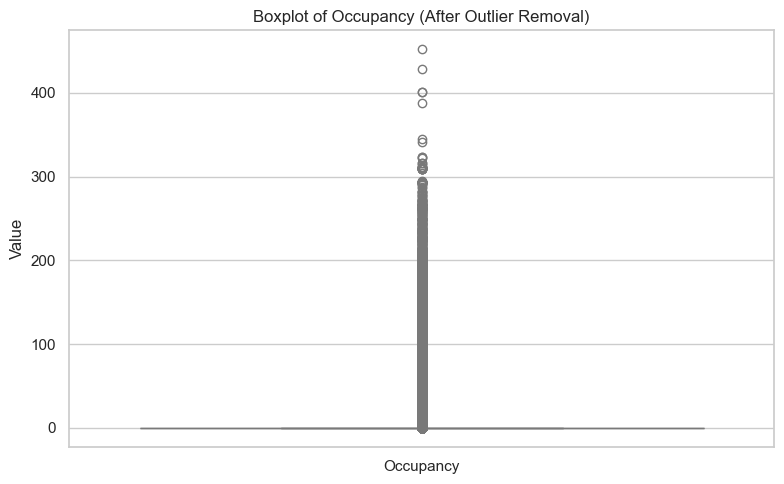

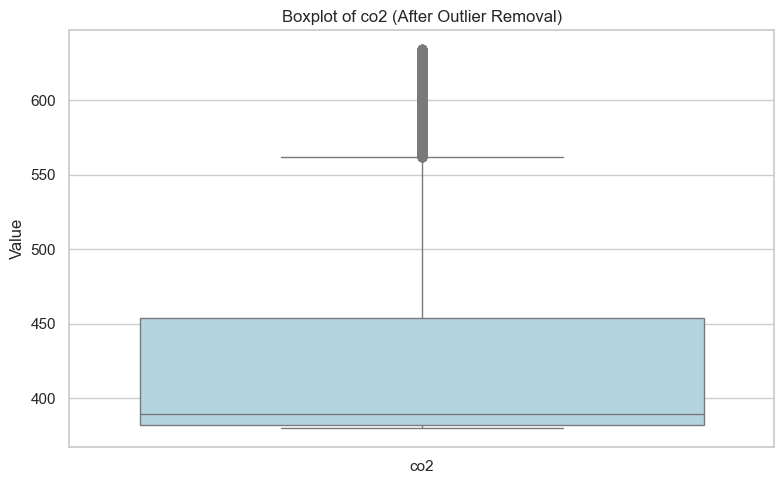

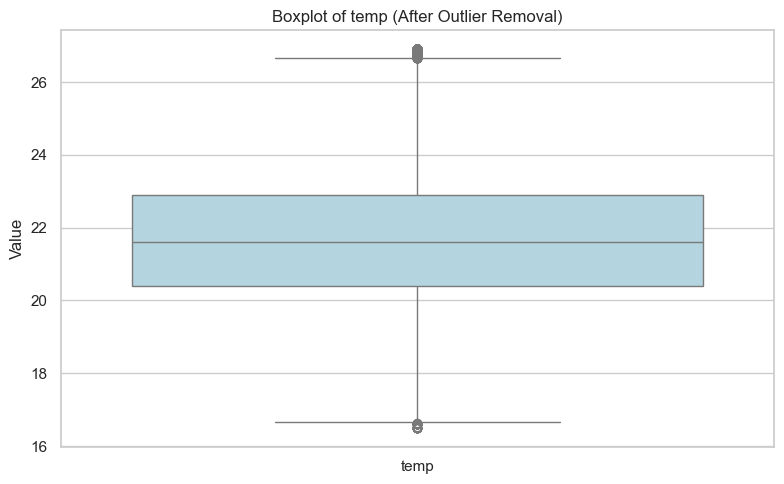

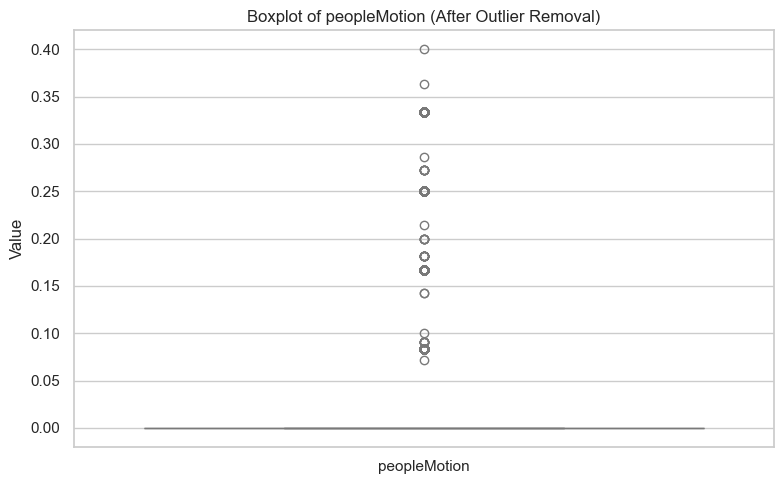

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Metrics to visualize
metrics_to_plot = ['Occupancy', 'co2', 'temp', 'peopleMotion']

# Plot boxplots for each selected metric
for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        x='metric_name',
        y='value',
        data=merged_df_cleaned[merged_df_cleaned['metric_name'] == metric],
        color='lightblue'
    )
    plt.title(f"Boxplot of {metric} (After Outlier Removal)")
    plt.xlabel("")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()


<Axes: title={'center': 'Average Occupancy by Hour'}, xlabel='start_time'>

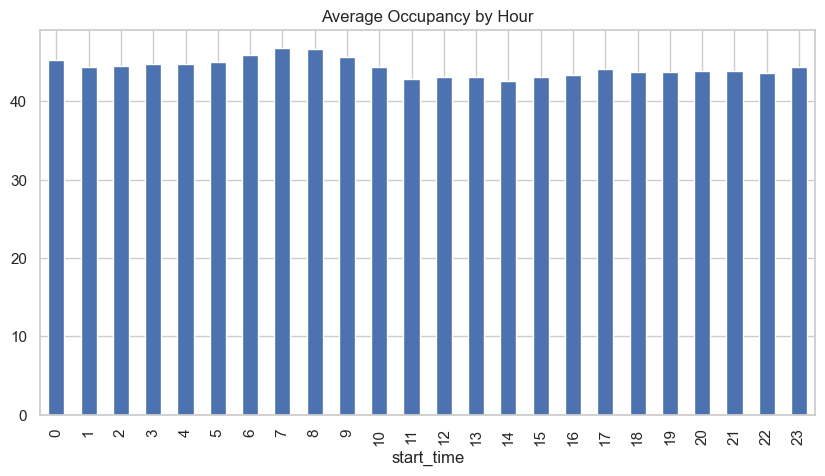

In [18]:
hourly_occupancy = merged_df_cleaned.groupby(merged_df_cleaned['start_time'].dt.hour)['value'].mean()
hourly_occupancy.plot(kind='bar', figsize=(10,5), title='Average Occupancy by Hour')


In [19]:
merged_df_cleaned['is_peak_hour'] = merged_df_cleaned['start_time'].dt.hour.between(7, 10)


In [20]:
def extract_room_type(name):
    name = str(name).lower()
    if 'seminar' in name:
        return 'Seminar Room'
    elif 'lecture' in name:
        return 'Lecture Hall'
    elif 'restroom' in name or 'toilet' in name:
        return 'Restroom'
    elif 'corridor' in name:
        return 'Corridor'
    elif 'lobby' in name:
        return 'Lobby'
    elif 'lab' in name:
        return 'Lab'
    elif 'meeting' in name:
        return 'Meeting Room'
    else:
        return 'Other'

merged_df_cleaned['room_type'] = merged_df_cleaned['display_name'].apply(extract_room_type)


In [21]:
# Compute average occupancy per room
room_avg = merged_df_cleaned.groupby('display_name')['value'].mean()

# Find median occupancy across all rooms
median_occupancy = room_avg.median()

# Define high or low usage per room
room_usage_category = room_avg.apply(lambda x: 'High' if x > median_occupancy else 'Low')

# Map it back to the main DataFrame
merged_df_cleaned['usage_category'] = merged_df_cleaned['display_name'].map(room_usage_category)


In [22]:
print(merged_df_cleaned[['start_time', 'is_peak_hour', 'room_type', 'usage_category']].head())


                 start_time  is_peak_hour     room_type usage_category
0 2025-04-25 11:00:00+00:00         False         Other           High
1 2025-04-25 11:00:00+00:00         False         Other            Low
2 2025-04-25 11:00:00+00:00         False         Other            Low
3 2025-04-25 11:00:00+00:00         False  Seminar Room           High
4 2025-04-25 11:00:00+00:00         False  Seminar Room            Low


C:\Users\chira\AppData\Local\Temp\ipykernel_15496\1165380351.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged_df_cleaned[merged_df_cleaned['metric_name'] == 'Occupancy'],
C:\Users\chira\AppData\Local\Temp\ipykernel_15496\1165380351.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_df_cleaned[merged_df_cleaned['metric_name'] == 'Occupancy'],


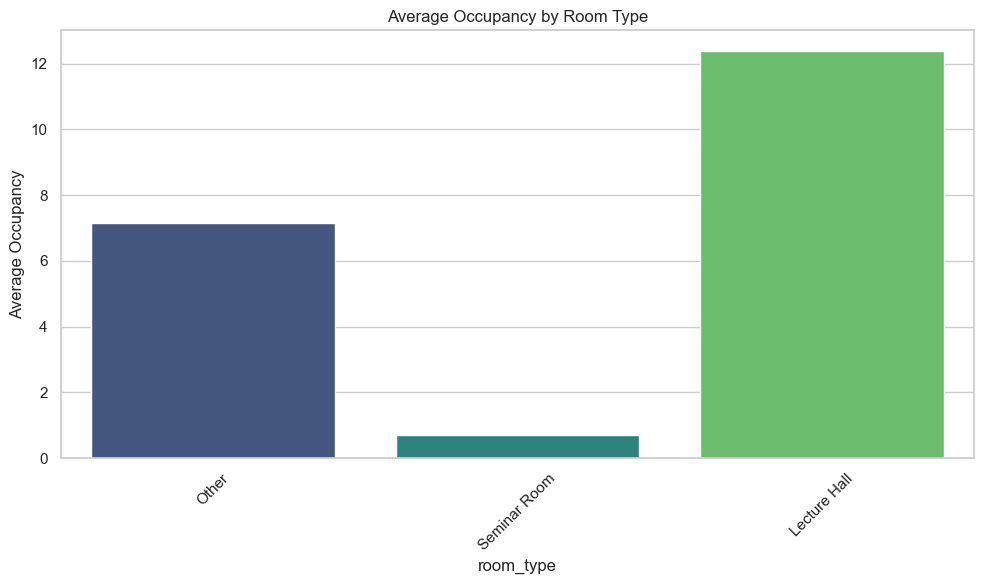

In [23]:

# Optional: Visualize occupancy by room type
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_df_cleaned[merged_df_cleaned['metric_name'] == 'Occupancy'],
            x="room_type", y="value", estimator="mean", ci=None, palette="viridis")
plt.title("Average Occupancy by Room Type")
plt.ylabel("Average Occupancy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\chira\AppData\Local\Temp\ipykernel_15496\486939699.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=room_avg_occupancy.index, y=room_avg_occupancy.values, palette="coolwarm")


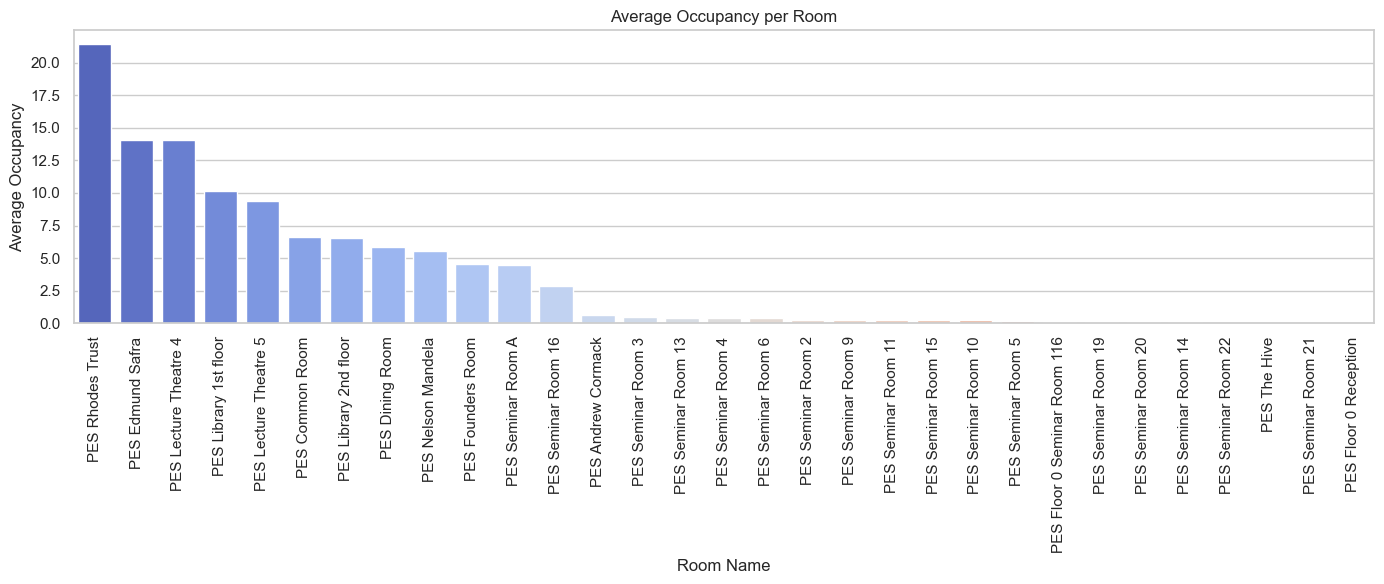

In [24]:
# Filter only Occupancy metric
occupancy_df = merged_df_cleaned[merged_df_cleaned['metric_name'] == 'Occupancy']

# Compute average occupancy per room
room_avg_occupancy = occupancy_df.groupby('display_name')['value'].mean().sort_values(ascending=False)

# Plot average occupancy for each room
plt.figure(figsize=(14, 6))
sns.barplot(x=room_avg_occupancy.index, y=room_avg_occupancy.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Average Occupancy per Room")
plt.ylabel("Average Occupancy")
plt.xlabel("Room Name")
plt.tight_layout()
plt.show()


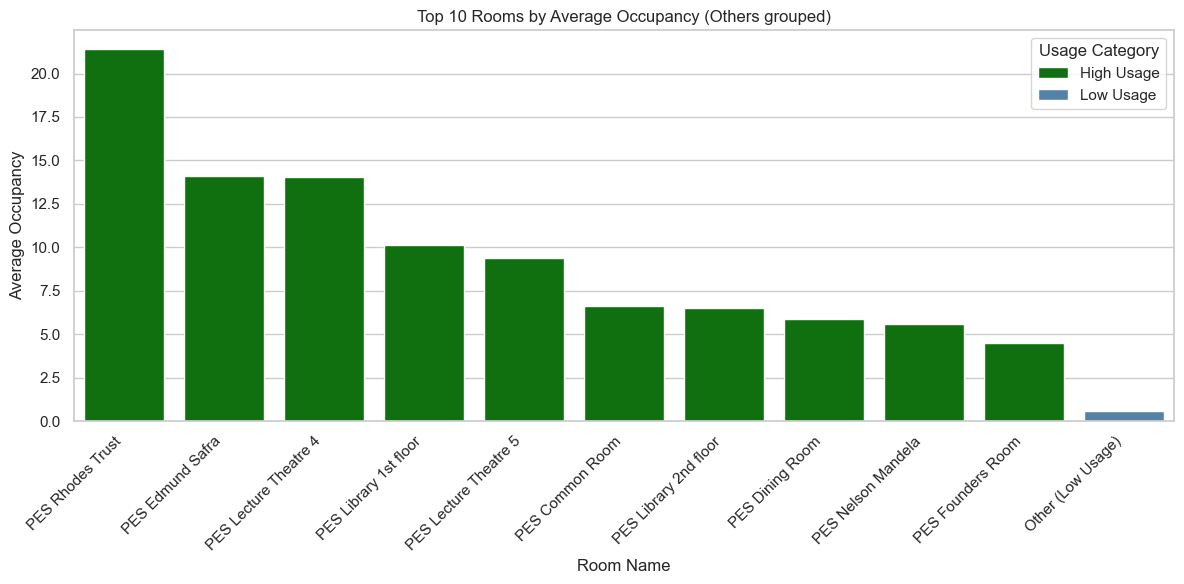

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Compute average occupancy per room
occupancy_by_room = (
    merged_df_cleaned[merged_df_cleaned['metric_name'] == 'Occupancy']
    .groupby('display_name')['value']
    .mean()
    .sort_values(ascending=False)
)

# Step 2: Keep top 10, group the rest into "Other (Low Usage)"
top_n = 10
top_rooms = occupancy_by_room.head(top_n)
other_sum = occupancy_by_room.iloc[top_n:].mean()  # use mean or sum depending on message
top_rooms['Other (Low Usage)'] = other_sum

# Step 3: Convert to DataFrame for plotting
plot_df = top_rooms.reset_index()
plot_df.columns = ['Room Name', 'Average Occupancy']

# Step 4: Add usage category for coloring
plot_df['Usage Category'] = ['High Usage'] * top_n + ['Low Usage']

# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x='Room Name', y='Average Occupancy', hue='Usage Category', dodge=False, palette={'High Usage': 'green', 'Low Usage': 'steelblue'})
plt.title("Top 10 Rooms by Average Occupancy (Others grouped)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [26]:
merged_df_cleaned[merged_df_cleaned['metric_name'] == 'Occupancy'].describe()


,id_x,value,geometry_id,hierarchy_id,portfolio_id_x,data_source_id,id_y,parent_id,longitude,latitude,portfolio_id_y,hour,dayofweek,month
count,1.747410e+05,174741.000000,174741.000000,0.0,174741.0,174741.000000,174741.000000,174741.0,174741.0,174741.0,174741.0,174741.000000,174741.000000,174741.000000
mean,4.028332e+07,3.905438,23610.150720,NaN,23457.0,1.378835,23960.002472,23728.0,0.0,0.0,23457.0,11.556389,2.912854,5.258623
std,1.074127e+07,17.500948,9.824891,NaN,0.0,2.861975,9.417749,0.0,0.0,0.0,0.0,6.927260,1.976708,1.055424
min,2.237051e+07,0.000000,23595.000000,NaN,23457.0,1.000000,23945.000000,23728.0,0.0,0.0,23457.0,0.000000,0.000000,3.000000
25%,3.201813e+07,0.000000,23602.000000,NaN,23457.0,1.000000,23952.000000,23728.0,0.0,0.0,23457.0,6.000000,1.000000,5.000000
50%,4.116082e+07,0.000000,23609.000000,NaN,23457.0,1.000000,23959.000000,23728.0,0.0,0.0,23457.0,12.000000,3.000000,5.000000
75%,4.945307e+07,0.000000,23617.000000,NaN,23457.0,1.000000,23967.000000,23728.0,0.0,0.0,23457.0,18.000000,5.000000,6.000000
max,5.749993e+07,452.000000,23642.000000,NaN,23457.0,23.000000,23981.000000,23728.0,0.0,0.0,23457.0,23.000000,6.000000,7.000000


In [27]:
merged_df_cleaned.shape

(1305472, 31)